# Linear Regression Outliers 1.5

## Loading libaries and dataset 

In [2]:
# Based on Dataset mit Fuel Consumption, top number of categorical variables:10 and minimum category percentage: 10%
# All cat variables are already onehot encoded

# Import staandard libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for the modeling.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Linear regression will use python statsmodels library instead of sickit learn because the former offers a more comprehensive report
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# enabling the display of all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)



In [3]:
# reading the file
df=pd.read_parquet(r'C:\Users\alexa\Downloads\ProjectCO2--no Github\Data\minimal_withoutfc_dupesdropped_frequencies_area_outliers1.5_tn20_mcp00.10.parquet')

In [4]:
# Check summary

# Enabling the display of all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Get the data types of each column
data_types = df.dtypes

# Get the number of unique values for each column
unique_values = df.nunique()

# Get the percentage of missing values for each column
missing_values = df.isnull().mean() * 100

# Combine the information into a DataFrame
summary_df = pd.DataFrame({
    'Data Type': data_types,
    'Unique Values': unique_values,
    'Missing Values (%)': missing_values
})

# Sort the summary DataFrame by 'Data Type' and then by 'Missing Values (%)' in descending order
summary_df = summary_df.sort_values(by=['Data Type', 'Missing Values (%)'], ascending=[True, False])

# Group by data type and display
grouped_summary_df = summary_df.groupby('Data Type')

# Print the summary DataFrame grouped by data type
for dtype, group in grouped_summary_df:
    print(f"\nData Type: {dtype}")
    print(group)
    
# Display the cleaned DataFrame shape
print("\nDataFrame Shape:", df.shape)



Data Type: uint8
                             Data Type  Unique Values  Missing Values (%)
Mh_AUDI AG                       uint8              2                 0.0
Mh_AUTOMOBILES CITROEN           uint8              2                 0.0
Mh_AUTOMOBILES PEUGEOT           uint8              2                 0.0
Mh_BMW AG                        uint8              2                 0.0
Mh_DACIA                         uint8              2                 0.0
Mh_FIAT GROUP                    uint8              2                 0.0
Mh_FORD WERKE GMBH               uint8              2                 0.0
Mh_JAGUAR LAND ROVER LIMITED     uint8              2                 0.0
Mh_MERCEDES-BENZ AG              uint8              2                 0.0
Mh_OPEL AUTOMOBILE               uint8              2                 0.0
Mh_PORSCHE                       uint8              2                 0.0
Mh_PSA                           uint8              2                 0.0
Mh_RENAULT          

## Micro-preprocessing: Collinearity

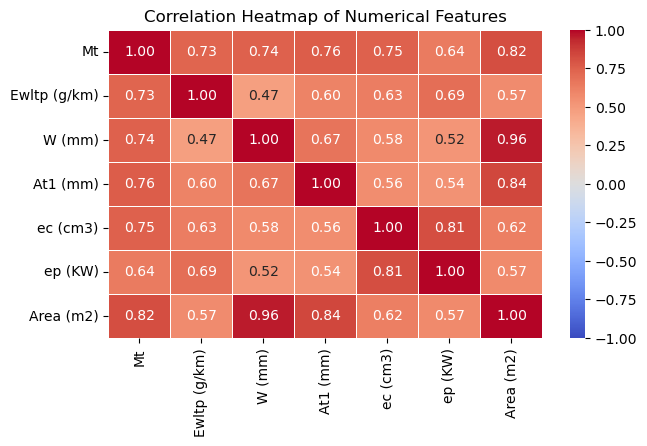

In [5]:
# Select only the numerical columns from the DataFrame

numerical_cols = df.select_dtypes(include=['float32']).columns

# Compute the correlation matrix
corr_matrix = df[numerical_cols].corr()

# Plot the heatmap
plt.figure(figsize=(7, 4))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

Interpretation and plan to fix:

For two variables, correlations above 0.8 are generally a concern. These variables can be either dropped or treated via regularization. 

drop:
- W (mm) and keep Area. 

The rest will be treated via Elastic Net 

Andreas 02/Nov via Slack: "Fazit: Ich plädiere daür, auf jeden Fall zusätzlich noch W (mm) rauszuschmeissen (m (kg) und At2  (mm) sind ja schon raus). At1 und auch beide Motor-Parameter (ec und ep) würde ich trotz Kollinearität mitschleifen und ggf. schauen, ob man durch rumspielen an den Parametern des ElasticNet noch was erreichen kann (und XGBoost und DNNs sollten mit Kollinearität ja ohnehin nicht so große Probleme haben)."

In [6]:
df_reduced = df.drop(columns=['W (mm)'])


In [7]:
df = df_reduced  # Reassigning back to df

Data Preparation and LR with Elastic Net

In [9]:
# Step 1: Split data into features and target

target_column = 'Ewltp (g/km)'  # Target column
X = df.drop(columns=[target_column])  # Features
y = df[target_column]  # Target variable

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train an Elastic Net model with Cross-Validation
enet_cv = ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.9], random_state=42)
enet_cv.fit(X_train_scaled, y_train)

## NOTE: the model ElasticNetCV itself is a type of linear regression model that incorporates Elastic Net regularization.

# Step 5: Display best parameters (alpha and l1_ratio)
print("Best alpha:", enet_cv.alpha_)
print("Best l1_ratio:", enet_cv.l1_ratio_)

# Step 6: Make predictions
y_train_pred = enet_cv.predict(X_train_scaled)
y_test_pred = enet_cv.predict(X_test_scaled)


Best alpha: 0.023315948830508554
Best l1_ratio: 0.9


Interpretation: 

The alpha parameter controls the overall strength of regularization. The chosen value, 0.025, is relatively small, suggesting that the model doesn’t need very strong regularization to perform well on your data. This indicates that the dataset likely has good predictive information, and only a slight amount of regularization is necessary to stabilize the model’s predictions and avoid overfitting.

The l1_ratio parameter controls the balance between L1 (Lasso) and L2 (Ridge) regularization (l1_ = 1 pure Lasso, and L1- = 0 pure Ridge): With l1_ratio = 0.9, the model is mostly applying Lasso regularization, with a small influence from Ridge regularization. This combination suggests that the model benefits from sparsity (reducing some feature coefficients to zero) while maintaining a bit of Ridge’s shrinkage effect to handle any multicollinearity among features.

Recall: 
Lasso regularization, which tends to produce sparse models by setting some coefficients to zero.
Ridge regularization, which shrinks coefficients but keeps all features in the model.



## Model Evaluation

In [14]:
# Model Evaluation

# Step 7: Evaluate the model with R-squared and MSE
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse_lr = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2_lr = r2_score(y_test, y_test_pred)

# Save metrics for Linear Regression
model_metrics['Linear Regression'] = {'MSE': test_mse_lr, 'R²': test_r2_lr}

print(f"Training MSE: {train_mse}")
print(f"Test MSE Lr: {test_mse_lr}")
print(f"Training R2: {train_r2}")
print(f"Test R2 Lr: {test_r2_lr}")

Training MSE: 152.83562007816377
Test MSE Lr: 153.00555257661827
Training R2: 0.8157836918726336
Test R2 Lr: 0.816275815715501


Interpretation: 

An R² value of 0.81 indicates that the model explains about 81% of the variance in the target variable. This high R² suggests that the model is fitting the data well.
The fact that both the training and test R² values are very close shows that the model generalizes well to unseen data. It doesn’t appear to be overfitting or underfitting.


## Feature importance

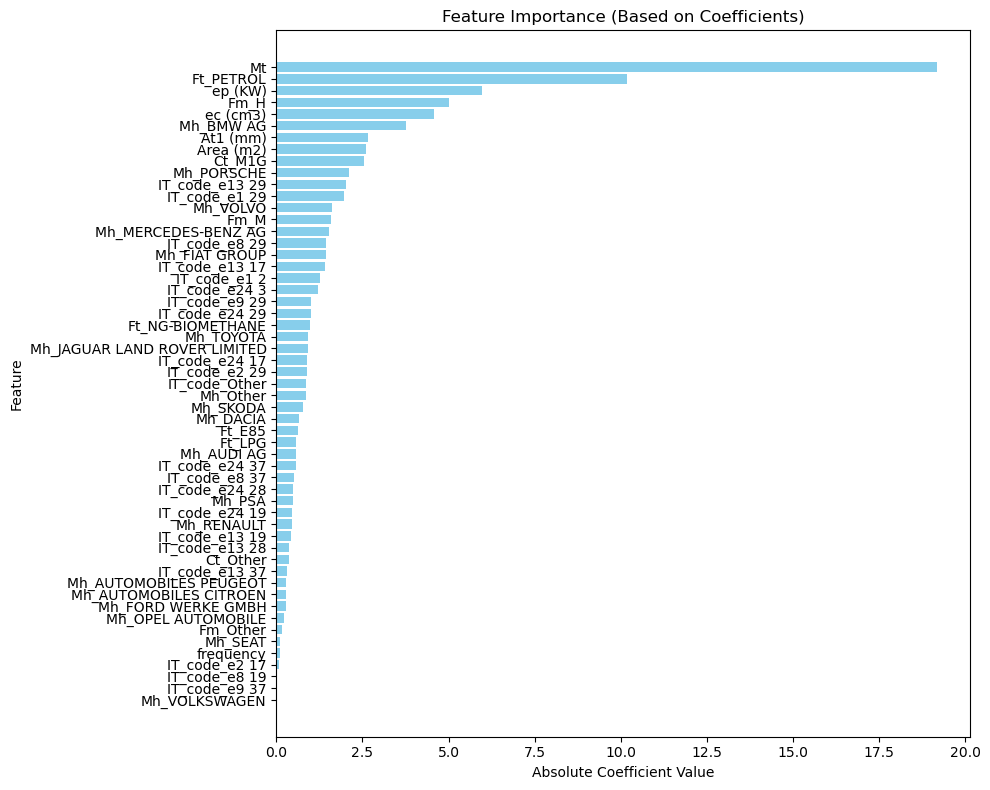

In [9]:
# Get feature importance (absolute value of coefficients)
feature_importance = np.abs(enet_cv.coef_)
feature_names = X.columns  # Assuming X is the DataFrame with feature names

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance (Based on Coefficients)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

Interpretation:
 

## Cross Validation (5-fold)

In [10]:
# Altough the model performs already very good on unseen data. Let's further evaluate performance via CV 
# Note that cross validation used the entire data set (X_scaled). Therefore, the following steps are neccesary. 


# Step 1: Prepare features and target
#target_column = 'Ewltp (g/km)'
#X = df.drop(columns=[target_column])
#y = df[target_column]

# Step 2: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Define the Elastic Net model with Cross-Validation (GridSearchCV can be used for alpha/l1_ratio tuning)
enet_cv = ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.9], random_state=42)

# Step 4: Perform cross-validation
cv_scores = cross_val_score(enet_cv, X_scaled, y, cv=5, scoring='r2')  # Use 'neg_mean_squared_error' for MSE

# Step 5: Output results
print("Cross-validated R-squared scores:", cv_scores)
print("Mean R-squared across folds:", cv_scores.mean())
print("Standard deviation of R-squared across folds:", cv_scores.std())


Cross-validated R-squared scores: [0.77616261 0.77946659 0.81600873 0.81676209 0.78866563]
Mean R-squared across folds: 0.7954131279976097
Standard deviation of R-squared across folds: 0.017608864355570495


Interpretation:
The average R² score across all folds, which is approximately 0.80 is strong, meaning the model explains about 80% of the variance in the target variable across different subsets of data.
Note that this is also close to the test R².
Since both the test R² and cross-validated R² scores are around 0.80, it implies that the model’s performance is consistent across different subsets and also aligns with the hold-out test set. This consistency is a sign of a well-balanced model.



# Linear Regression Outliers 3

In [15]:

# Import staandard libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for the modeling.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Linear regression will use python statsmodels library instead of sickit learn because the former offers a more comprehensive report
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# enabling the display of all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [16]:
# reading the file
df=pd.read_parquet(r'C:\Users\alexa\Downloads\ProjectCO2--no Github\Data\minimal_withoutfc_dupesdropped_frequencies_area_outliers3.0_tn20_mcp00.10.parquet')

In [17]:
# Check summary

# Enabling the display of all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Get the data types of each column
data_types = df.dtypes

# Get the number of unique values for each column
unique_values = df.nunique()

# Get the percentage of missing values for each column
missing_values = df.isnull().mean() * 100

# Combine the information into a DataFrame
summary_df = pd.DataFrame({
    'Data Type': data_types,
    'Unique Values': unique_values,
    'Missing Values (%)': missing_values
})

# Sort the summary DataFrame by 'Data Type' and then by 'Missing Values (%)' in descending order
summary_df = summary_df.sort_values(by=['Data Type', 'Missing Values (%)'], ascending=[True, False])

# Group by data type and display
grouped_summary_df = summary_df.groupby('Data Type')

# Print the summary DataFrame grouped by data type
for dtype, group in grouped_summary_df:
    print(f"\nData Type: {dtype}")
    print(group)
    
# Display the cleaned DataFrame shape
print("\nDataFrame Shape:", df.shape)


Data Type: uint8
                             Data Type  Unique Values  Missing Values (%)
Mh_AUDI AG                       uint8              2                 0.0
Mh_AUTOMOBILES CITROEN           uint8              2                 0.0
Mh_AUTOMOBILES PEUGEOT           uint8              2                 0.0
Mh_BMW AG                        uint8              2                 0.0
Mh_DACIA                         uint8              2                 0.0
Mh_FIAT GROUP                    uint8              2                 0.0
Mh_FORD WERKE GMBH               uint8              2                 0.0
Mh_JAGUAR LAND ROVER LIMITED     uint8              2                 0.0
Mh_MERCEDES-BENZ AG              uint8              2                 0.0
Mh_OPEL AUTOMOBILE               uint8              2                 0.0
Mh_PORSCHE                       uint8              2                 0.0
Mh_PSA                           uint8              2                 0.0
Mh_RENAULT          

## Micro-preprocessing: Collinearity

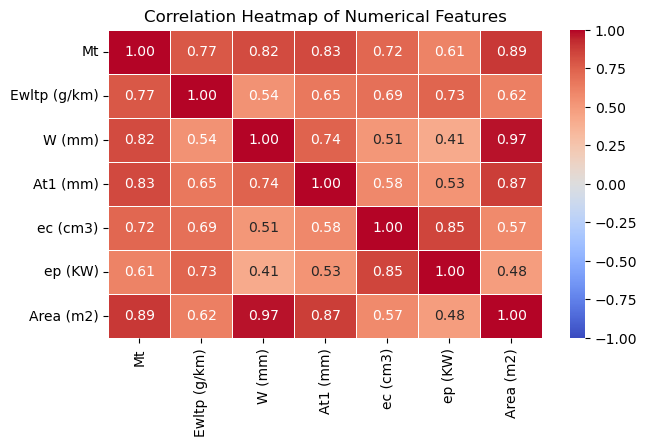

In [19]:
# Select only the numerical columns from the DataFrame

numerical_cols = df.select_dtypes(include=['float32']).columns

# Compute the correlation matrix
corr_matrix = df[numerical_cols].corr()

# Plot the heatmap
plt.figure(figsize=(7, 4))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

Interpretation and plan to fix:

For two variables, correlations above 0.8 are generally a concern. These variables can be either dropped or treated via regularization. 

drop:
- W and keep  Area. 
The rest will be treated via Elastic Net (regularization technique that combines L1 (Lasso) and L2 (Ridge) regularization)

In [20]:
df_reduced = df.drop(columns=['W (mm)'])

In [21]:
df = df_reduced  # Reassigning back to df

## Data Preparation and LR with Elastic Net

In [22]:
# Step 1: Split data into features and target

target_column = 'Ewltp (g/km)'  # Target column
X = df.drop(columns=[target_column])  # Features
y = df[target_column]  # Target variable

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train an Elastic Net model with Cross-Validation
enet_cv = ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.9], random_state=42)
enet_cv.fit(X_train_scaled, y_train)

## NOTE: the model ElasticNetCV itself is a type of linear regression model that incorporates Elastic Net regularization.

# Step 5: Display best parameters (alpha and l1_ratio)
print("Best alpha:", enet_cv.alpha_)
print("Best l1_ratio:", enet_cv.l1_ratio_)

# Step 6: Make predictions
y_train_pred = enet_cv.predict(X_train_scaled)
y_test_pred = enet_cv.predict(X_test_scaled)

Best alpha: 0.029418569473813518
Best l1_ratio: 0.9


Interpretation: 

The alpha parameter controls the overall strength of regularization. The chosen value, 0.029, is relatively small, suggesting that the model doesn’t need very strong regularization to perform well on your data. This indicates that the dataset likely has good predictive information, and only a slight amount of regularization is necessary to stabilize the model’s predictions and avoid overfitting.

The l1_ratio parameter controls the balance between L1 (Lasso) and L2 (Ridge) regularization (l1_ = 1 pure Lasso, and L1- = 0 pure Ridge): With l1_ratio = 0.9, the model is mostly applying Lasso regularization, with a small influence from Ridge regularization. This combination suggests that the model benefits from sparsity (reducing some feature coefficients to zero) while maintaining a bit of Ridge’s shrinkage effect to handle any multicollinearity among features.

Recall: 
Lasso regularization, which tends to produce sparse models by setting some coefficients to zero.
Ridge regularization, which shrinks coefficients but keeps all features in the model.

## Model Evaluation

In [28]:
# Model Evaluation

# Step 7: Evaluate the model with R-squared and MSE
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse_lr2 = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2_lr2 = r2_score(y_test, y_test_pred)

# Save metrics for Linear Regression
model_metrics['Linear Regression'] = {'MSE': test_mse_lr2, 'R²': test_r2_lr}

print(f"Training MSE: {train_mse}")
print(f"Test MSE lr2: {test_mse_lr2}")
print(f"Training R2: {train_r2}")
print(f"Test R2 lr2: {test_r2_lr2}")

Training MSE: 127.68246685602055
Test MSE lr2: 128.46573717200084
Training R2: 0.8905386663132676
Test R2 lr2: 0.889924146192219


Interpretation: An R² value of 0.88 indicates that the model explains about 88% of the variance in the target variable. This high R² suggests that the model is fitting the data well, but it can be improved.
The fact that both the training and test R² values are very close shows that the model generalizes well to unseen data. It doesn’t appear to be overfitting or underfitting.

## Feature Importance

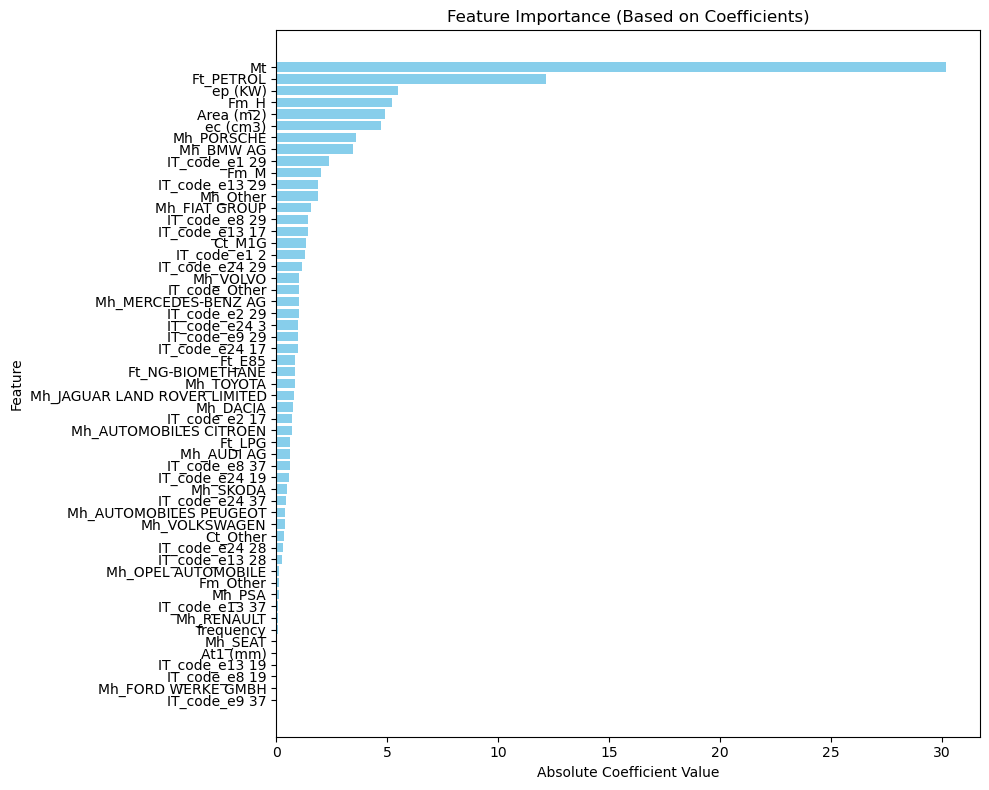

In [24]:
# Get feature importance (absolute value of coefficients)
feature_importance = np.abs(enet_cv.coef_)
feature_names = X.columns  # Assuming X is the DataFrame with feature names

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance (Based on Coefficients)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

Interpretation: Ewltp mass followed by Ft Petrol are the leading variables explaining Ewltp. 

## Cross Validation (5-fold)

In [25]:
# Altough the model performs already very good on unseen data. Let's further evaluate performance via CV 
# Note that cross validation used the entire data set (X_scaled). Therefore, the following steps are neccesary. 


# Step 1: Prepare features and target
#target_column = 'Ewltp (g/km)'
#X = df.drop(columns=[target_column])
#y = df[target_column]

# Step 2: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Define the Elastic Net model with Cross-Validation (GridSearchCV can be used for alpha/l1_ratio tuning)
enet_cv = ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.9], random_state=42)

# Step 4: Perform cross-validation
cv_scores = cross_val_score(enet_cv, X_scaled, y, cv=5, scoring='r2')  # Use 'neg_mean_squared_error' for MSE

# Step 5: Output results
print("Cross-validated R-squared scores:", cv_scores)
print("Mean R-squared across folds:", cv_scores.mean())
print("Standard deviation of R-squared across folds:", cv_scores.std())

Cross-validated R-squared scores: [0.85771661 0.85134637 0.89473865 0.89235247 0.89237902]
Mean R-squared across folds: 0.8777066226101098
Standard deviation of R-squared across folds: 0.019049057797127088


Interpretation: 
The average R² score across all folds, which is approximately 0.87 is strong, meaning the model explains about 87% of the variance in the target variable across different subsets of data.
Note that this is also similar to the test R².
Since both the test R² and cross-validated R² scores are around 0.86-87, it implies that the model’s performance is consistent across different subsets and also aligns with the hold-out test set. This consistency is a sign of a well-balanced model.

# Ensemble XGBoost (Extreme Gradient Boosting) - Outliers 3

In [1]:
# Based on Dataset without Fuel Consumption, top number of categorical variables:10 and minimum category percentage: 10%
# All cat variables are already onehot encoded

# Import staandard libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for the modeling.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Linear regression will use python statsmodels library instead of sickit learn because the former offers a more comprehensive report
import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV

import shap

from sklearn.model_selection import cross_val_score

# enabling the display of all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
# reading the file
df=pd.read_parquet(r'C:\Users\alexa\Downloads\ProjectCO2--no Github\Data\minimal_withoutfc_dupesdropped_frequencies_area_outliers3.0_tn20_mcp00.10.parquet')

In [3]:
# Check summary

# Enabling the display of all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Get the data types of each column
data_types = df.dtypes

# Get the number of unique values for each column
unique_values = df.nunique()

# Get the percentage of missing values for each column
missing_values = df.isnull().mean() * 100

# Combine the information into a DataFrame
summary_df = pd.DataFrame({
    'Data Type': data_types,
    'Unique Values': unique_values,
    'Missing Values (%)': missing_values
})

# Sort the summary DataFrame by 'Data Type' and then by 'Missing Values (%)' in descending order
summary_df = summary_df.sort_values(by=['Data Type', 'Missing Values (%)'], ascending=[True, False])

# Group by data type and display
grouped_summary_df = summary_df.groupby('Data Type')

# Print the summary DataFrame grouped by data type
for dtype, group in grouped_summary_df:
    print(f"\nData Type: {dtype}")
    print(group)
    
# Display the cleaned DataFrame shape
print("\nDataFrame Shape:", df.shape)


Data Type: uint8
                             Data Type  Unique Values  Missing Values (%)
Mh_AUDI AG                       uint8              2                 0.0
Mh_AUTOMOBILES CITROEN           uint8              2                 0.0
Mh_AUTOMOBILES PEUGEOT           uint8              2                 0.0
Mh_BMW AG                        uint8              2                 0.0
Mh_DACIA                         uint8              2                 0.0
Mh_FIAT GROUP                    uint8              2                 0.0
Mh_FORD WERKE GMBH               uint8              2                 0.0
Mh_JAGUAR LAND ROVER LIMITED     uint8              2                 0.0
Mh_MERCEDES-BENZ AG              uint8              2                 0.0
Mh_OPEL AUTOMOBILE               uint8              2                 0.0
Mh_PORSCHE                       uint8              2                 0.0
Mh_PSA                           uint8              2                 0.0
Mh_RENAULT          

## Micro-preprocessing: Outliers

It's needed? 

Robustness of Tree-Based Models: XGBoost is a tree-based algorithm, and tree models are generally more robust to outliers because they split data based on decision thresholds rather than minimizing an error metric like mean squared error (as in linear regression).
Gradient Boosting Resilience: Since XGBoost uses gradient boosting, it iteratively builds trees to correct errors from previous trees. This process is inherently robust against extreme values, as each successive tree focuses on parts of the data that previous trees handled poorly, rather than being influenced by the outliers in every tree.

However: 
Highly Skewed Data: If your data has extreme outliers that heavily skew the distributions of certain features, XGBoost might benefit from outlier treatment or scaling, as these extreme values could slightly impact the model's learning process, especially in the early trees.
Data Quality and Stability: Removing or treating outliers can improve the quality of your data and make the model more stable and interpretable. In some cases, it can also enhance the model's generalization performance.

Plan:

If in Doubt: Start by running XGBoost without explicitly handling outliers and evaluate its performance.
If Issues Arise: If you observe erratic predictions or suspect that outliers are skewing the model's focus, you could then preprocess the outliers and compare performance.

## Micro-preprocessing: Collinearity

It is needed? 

Tree-Based Robustness to Collinearity: XGBoost, like other tree-based models, is inherently more robust to multicollinearity than linear models. Decision trees split based on thresholds for each feature independently, so they aren’t as affected by the presence of collinear features.
Automatic Feature Selection: XGBoost tends to focus on the most predictive features during the boosting process, and collinear features may end up with lower importance or be ignored in later trees, depending on their contribution to reducing error. As a result, the model can often "self-manage" redundant information due to collinearity.

However, 

Improving Model Efficiency: Highly collinear features add redundant information, which can increase the computational cost of training. Removing some of these redundant features can speed up training without significantly affecting model performance.

Reducing Overfitting Risk in Small Datasets: Although XGBoost is robust to collinearity, if the dataset is small and has highly correlated features, this redundancy can still slightly increase the risk of overfitting. Reducing collinearity in this context may lead to a more stable model.

Interpreting Feature Importance: If you’re interpreting feature importances or SHAP values, collinearity can make it harder to discern which features are truly impactful, as highly correlated features may "share" importance. Removing or combining collinear features can improve interpretability.

Plan: I will handle collinearity

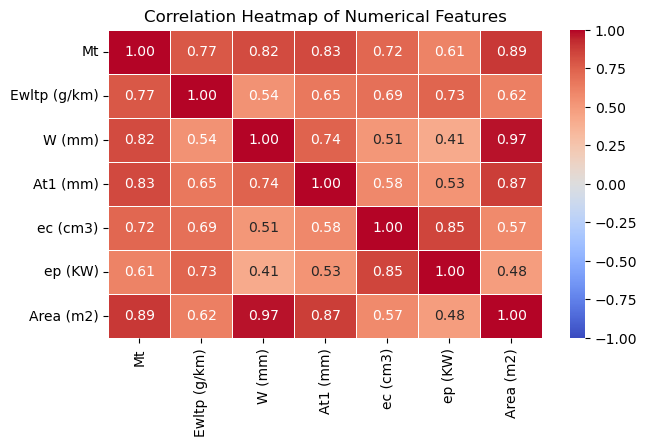

In [4]:
# Select only the numerical columns from the DataFrame

numerical_cols = df.select_dtypes(include=['float32']).columns

# Compute the correlation matrix
corr_matrix = df[numerical_cols].corr()

# Plot the heatmap
plt.figure(figsize=(7, 4))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

Interpretation and plan to fix:

For two variables, correlations above 0.8 are generally a concern. These variables can be either dropped or treated via regularization. 

drop:
- W and keep  Area. 
The rest will be treated via Elastic Net (regularization technique that combines L1 (Lasso) and L2 (Ridge) regularization)



In [5]:
df_reduced = df.drop(columns=['W (mm)'])

In [6]:
df = df_reduced  # Reassigning back to df

## Data Preparation and XG Boost

In [7]:
# Step 1: Prepare the data
X = df.drop(columns=['Ewltp (g/km)'])  # Features (replace with your target column name)
y = df['Ewltp (g/km)']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Note: XGBoost does not require scaling of numerical variables. XGBoost uses decision trees as base learners, and decision trees are generally insensitive to the scale of features

# Step 2: Initialize and train the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42) # Default parameters: max_depth=6, learning_rate = 0.3, n_estimators =100 (number of boosting rounds), booster = "gbtree" (which booster to use: gbtree, gblinear, or dart)
xgb_model.fit(X_train, y_train)

# Step 3: Make predictions
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

## Model Evaluation

In [10]:
# Step 4: Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse_xg = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2_xg = r2_score(y_test, y_test_pred)

# Save metrics for Linear Regression
model_metrics['XG Boost'] = {'MSE': test_mse_xg, 'R²': test_r2_xg}

print(f"Training MSE: {train_mse}")
print(f"Test MSE XG: {test_mse_xg}")
print(f"Training R-squared: {train_r2}")
print(f"Test R-squared XG: {test_r2_xg}")

Training MSE: 32.39582061767578
Test MSE XG: 32.95991516113281
Training R-squared: 0.9722272753715515
Test R-squared XG: 0.9717583060264587


Interpretation:

The R-squared values for both training and test sets are quite high (around 0.97). 
This indicates that approximately 97% of the variance in the target variable (CO₂ emissions, or "Ewltp (g/km)" in this case) is explained by the model, which is a strong indication of good model performance.
These results are better than linear regression. 
Test R-squared, which is very close to the training R-squared, suggests that the model generalizes well to unseen data, indicating no significant overfitting.

Let's see if we can improve the model by tuning parameters and looking for the best ones.


## Data Preparation and XG Boost with Grid Search (Execution time: 120 min)

In [ ]:
# Define the parameter grid

param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [3, 5, 7],          # Maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate for boosting
    'subsample': [0.7, 0.8, 1.0],    # Subsample ratio of the training instance
    'colsample_bytree': [0.7, 0.8, 1.0] # Subsample ratio of columns when constructing each tree
}

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use negative MSE as scoring metric
    cv=3,  # 3-fold cross-validation for speed
    verbose=1,
    n_jobs=-1  # Use all available cores for parallel processing
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Convert back to positive MSE
print("Best Parameters:", best_params)
print("Best MSE from Grid Search:", best_score)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_test_pred_best = best_model.predict(X_test)
test_mse_best = mean_squared_error(y_test, y_test_pred_best)
test_r2_best = r2_score(y_test, y_test_pred_best)

print(f"Best Model Test MSE: {test_mse_best}")
print(f"Best Model Test R-squared: {test_r2_best}")

#Results: 
#Fitting 3 folds for each of 243 candidates, totalling 729 fits
#Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'subsample': 1.0}
#Best MSE from Grid Search: 27.69585418701172
#Best Model Test MSE: 27.76150894165039
#Best Model Test R-squared: 0.9762125611305237

Fitting 3 folds for each of 243 candidates, totalling 729 fits


c:\Users\alexa\anaconda3\envs\aug24_bds_int---co2\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'subsample': 1.0}
Best MSE from Grid Search: 27.69585418701172
Best Model Test MSE: 27.76150894165039
Best Model Test R-squared: 0.9762125611305237


Interpretation: 
The model improved from Test R-squared: 0.96 to Best Model Test R-squared: 0.97

Explanation of Hyperparameters Chosen
- n_estimators: Controls the number of boosting rounds. Lower values (50-150) keep memory usage manageable.
- max_depth: Depth of each tree. Values of 3, 5, and 7 provide a balance between model complexity and performance.
- learning_rate: Step size shrinkage to prevent overfitting. Lower values (0.01-0.2) help maintain model stability.
- subsample and colsample_bytree: Control the fraction of samples and features used per tree. Smaller values reduce variance and memory load.

With this setup, I hope to be able to tune the XGBoost model efficiently within my system's memory limits (16 GB RAM).

In the next step I will use cross validation with the paramaters found. 

## Cross Validation (CV = 5)

In [ ]:
# Using the values found via Grid Search

# Initialize the XGBoost model with the best parameters obtained from Grid Search
xgb_model = xgb.XGBRegressor(
    n_estimators=150,         # Best n_estimators from Grid Search
    max_depth=7,              # Best max_depth from Grid Search
    learning_rate=0.2,        # Best learning_rate from Grid Search
    colsample_bytree=1.0,     # Best colsample_bytree from Grid Search
    subsample=0.8,            # Best subsample from Grid Search
    random_state=42
)

# Note: parameters such as max_features, min_samples_leaf, min_samples_split) are not used in XGBoost's XGBRegressor. 
# In XGBoost, similar control is achieved by tuning colsample_bytree, colsample_bylevel, and subsample.

# Perform 5-fold cross-validation on the model
# Scoring with R-squared to evaluate model's ability to explain variance
cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='r2')

# Print cross-validated R-squared scores
print("Cross-validated R-squared scores:", cv_scores)
print("Mean R-squared across folds:", np.mean(cv_scores))
print("Standard deviation of R-squared across folds:", np.std(cv_scores))

# Results

#Cross-validated R-squared scores: [0.95309782 0.95203137 0.97476494 0.97112    0.95989263]
# Mean R-squared across folds: 0.9621813535690308
# Standard deviation of R-squared across folds: 0.009263012896971545


Cross-validated R-squared scores: [0.95309782 0.95203137 0.97476494 0.97112    0.95989263]
Mean R-squared across folds: 0.9621813535690308
Standard deviation of R-squared across folds: 0.009263012896971545


Interpretation: 

These results imply that the XGBoost model is performing well, with high R-squared scores across all folds and low variability. 
This level of consistency and high performance across folds is a strong indicator that the model is well-suited to our dataset and problem, 
and no immediate further adjustments are needed.



## Feature importance : SHAP values

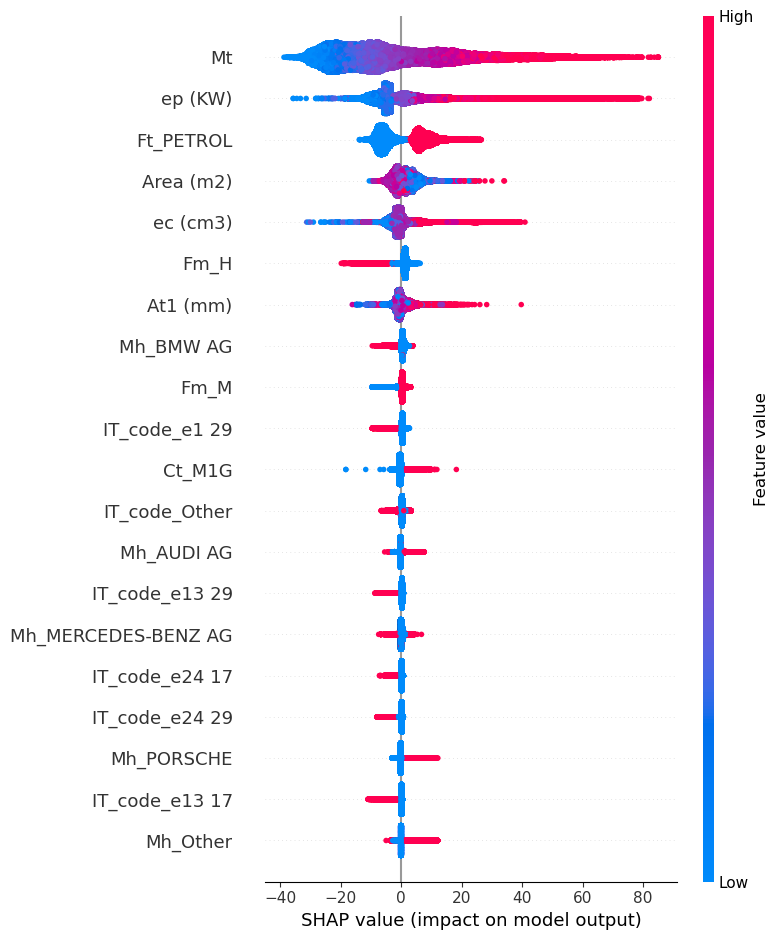

In [13]:
# SHAP does not necessarily require scaling. However, scaling may still be beneficial for interpretability. 

# Scaling numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data to DataFrame for SHAP compatibility and assign feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)


# Step 2: Initialize and train the XGBoost model


xgb_model = xgb.XGBRegressor(
    n_estimators=150,         # Best n_estimators from Grid Search
    max_depth=7,              # Best max_depth from Grid Search
    learning_rate=0.2,        # Best learning_rate from Grid Search
    colsample_bytree=1.0,     # Best colsample_bytree from Grid Search
    subsample=0.8,            # Best subsample from Grid Search
    random_state=42
)

xgb_model.fit(X_train_scaled_df, y_train)

# Step 3: Make predictions
y_train_pred = xgb_model.predict(X_train_scaled_df)
y_test_pred = xgb_model.predict(X_test_scaled_df)

# Step 4: SHAP Analysis
# Create a SHAP explainer object for the XGBoost model

explainer = shap.TreeExplainer(xgb_model)

# Explain predictions on the test set
shap_values = explainer(X_test_scaled_df)  # Do not use .values here

# Visualize SHAP values using a force plot for the first instance in the test set
shap.force_plot(explainer.expected_value, shap_values.values[0], X_test_scaled_df.iloc[0], feature_names=X.columns)

# Alternatively, use a summary plot for an overview of feature importance
shap.summary_plot(shap_values.values, X_test_scaled_df, feature_names=X.columns)


Interpretation: 


Interpretation:

Guide
1- Feature Importance:

The features are ranked vertically based on their importance. Features at the top have a larger impact on the model's predictions.
The color of the dots represents the direction of the feature's impact:
Red dots indicate features that increase the prediction (positive impact).
Blue dots indicate features that decrease the prediction (negative impact).

2- Feature Value Distribution:

The horizontal spread of the dots for a feature shows the range of values that the feature takes in the dataset.
A wider spread indicates a larger variation in the feature's values.

3- Feature Impact on Prediction:

The position of the dots on the horizontal axis shows how much a particular feature value contributes to the model's prediction.
Dots farther to the right indicate a larger positive contribution, while dots farther to the left indicate a larger negative contribution.


# Dense Neural Network (DNN) first attempt

In [2]:
# Based on Dataset without Fuel Consumption, top number of categorical variables:10 and minimum category percentage: 10%
# All cat variables are already onehot encoded

# Import staandard libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for the modeling.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping

# enabling the display of all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# reading the file
df=pd.read_parquet(r'C:\Users\alexa\Downloads\ProjectCO2--no Github\Data\minimal_withoutfc_dupesdropped_frequencies_area_outliers3.0_tn20_mcp00.10.parquet')

In [4]:
# Check summary

# Enabling the display of all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Get the data types of each column
data_types = df.dtypes

# Get the number of unique values for each column
unique_values = df.nunique()

# Get the percentage of missing values for each column
missing_values = df.isnull().mean() * 100

# Combine the information into a DataFrame
summary_df = pd.DataFrame({
    'Data Type': data_types,
    'Unique Values': unique_values,
    'Missing Values (%)': missing_values
})

# Sort the summary DataFrame by 'Data Type' and then by 'Missing Values (%)' in descending order
summary_df = summary_df.sort_values(by=['Data Type', 'Missing Values (%)'], ascending=[True, False])

# Group by data type and display
grouped_summary_df = summary_df.groupby('Data Type')

# Print the summary DataFrame grouped by data type
for dtype, group in grouped_summary_df:
    print(f"\nData Type: {dtype}")
    print(group)
    
# Display the cleaned DataFrame shape
print("\nDataFrame Shape:", df.shape)


Data Type: uint8
                             Data Type  Unique Values  Missing Values (%)
Mh_AUDI AG                       uint8              2                 0.0
Mh_AUTOMOBILES CITROEN           uint8              2                 0.0
Mh_AUTOMOBILES PEUGEOT           uint8              2                 0.0
Mh_BMW AG                        uint8              2                 0.0
Mh_DACIA                         uint8              2                 0.0
Mh_FIAT GROUP                    uint8              2                 0.0
Mh_FORD WERKE GMBH               uint8              2                 0.0
Mh_JAGUAR LAND ROVER LIMITED     uint8              2                 0.0
Mh_MERCEDES-BENZ AG              uint8              2                 0.0
Mh_OPEL AUTOMOBILE               uint8              2                 0.0
Mh_PORSCHE                       uint8              2                 0.0
Mh_PSA                           uint8              2                 0.0
Mh_RENAULT          

## Micro-preprocessing: Collinearity

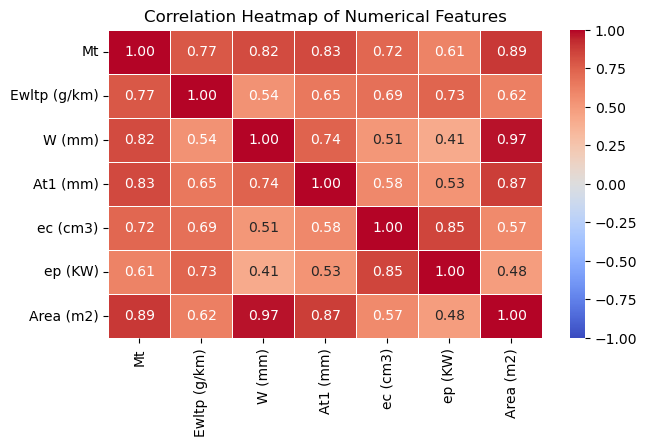

In [4]:
# Select only the numerical columns from the DataFrame

numerical_cols = df.select_dtypes(include=['float32']).columns

# Compute the correlation matrix
corr_matrix = df[numerical_cols].corr()

# Plot the heatmap
plt.figure(figsize=(7, 4))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

Interpretation and plan to fix:

For two variables, correlations above 0.8 are generally a concern. These variables can be either dropped or treated via regularization. 

drop:
- W and keep  Area. 
The rest will be treated via Elastic Net (regularization technique that combines L1 (Lasso) and L2 (Ridge) regularization)


In [5]:
df_reduced = df.drop(columns=['W (mm)'])

In [6]:
df = df_reduced  # Reassigning back to df

Data Preparation 

In [7]:
# Step 1: Split data into features and target

target_column = 'Ewltp (g/km)'
X = df.drop(columns=[target_column])
y = df[target_column]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Scale numerical features (assuming X is already preprocessed with categorical encoding)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scaling the target variable as well (optional but can be helpful)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Step 3: Further split X_train_scaled and y_train_scaled into training and validation sets
X_train_partial, X_val, y_train_partial, y_val = train_test_split(
    X_train_scaled, y_train_scaled, test_size=0.2, random_state=42)


## Modelling and summary

# Step 4: Build the Neural Network Model

model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Explicitly define the input shape
    Dense(64, activation='relu'),
    Dropout(0.2),  # Dropout layer to reduce overfitting
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer with one neuron for regression output
])

# Compile the model with MSE as the loss function and Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])

# Display the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,857 (38.50 KB)

 Trainable params: 9,857 (38.50 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Step 5: Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

# Step 6: Train the Model
history = model.fit(
    X_train_partial, y_train_partial,
    validation_data=(X_val, y_val),
    epochs=20,              # Reduced epochs - help manage memory usage.
    batch_size=16,          # Smaller batch size- help manage memory usage.
    callbacks=[early_stopping],  # Early stopping to prevent overfitting
    verbose=1
)

Epoch 1/20
81112/81112 ━━━━━━━━━━━━━━━━━━━━ 114s 1ms/step - loss: 0.1036 - mse: 0.1036 - val_loss: 0.0816 - val_mse: 0.0816
Epoch 2/20
81112/81112 ━━━━━━━━━━━━━━━━━━━━ 113s 1ms/step - loss: 0.0567 - mse: 0.0567 - val_loss: 0.0986 - val_mse: 0.0986
Epoch 3/20
81112/81112 ━━━━━━━━━━━━━━━━━━━━ 107s 1ms/step - loss: 0.0540 - mse: 0.0540 - val_loss: 0.0901 - val_mse: 0.0901
Epoch 4/20
81112/81112 ━━━━━━━━━━━━━━━━━━━━ 111s 1ms/step - loss: 0.0520 - mse: 0.0520 - val_loss: 0.0959 - val_mse: 0.0959
Epoch 5/20
81112/81112 ━━━━━━━━━━━━━━━━━━━━ 110s 1ms/step - loss: 0.0511 - mse: 0.0511 - val_loss: 0.0883 - val_mse: 0.0883
Epoch 6/20
81112/81112 ━━━━━━━━━━━━━━━━━━━━ 111s 1ms/step - loss: 0.0500 - mse: 0.0500 - val_loss: 0.0983 - val_mse: 0.0983
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


In [13]:
# Step 7: Evaluate the Model on the Test Set

# Transform the predictions back to the original scale
y_train_pred = scaler_y.inverse_transform(model.predict(X_train_scaled).flatten().reshape(-1, 1))
y_test_pred = scaler_y.inverse_transform(model.predict(X_test_scaled).flatten().reshape(-1, 1))

# Transform y_train and y_test back to the original scale
y_train_orig = scaler_y.inverse_transform(y_train_scaled.reshape(-1, 1))
y_test_orig = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))

train_mse = mean_squared_error(y_train_orig, y_train_pred)
test_mse_DNN1 = mean_squared_error(y_test_orig, y_test_pred)
train_r2 = r2_score(y_train_orig, y_train_pred)
test_r2_DNN1 = r2_score(y_test_orig, y_test_pred)

# Save metrics for model comparison
model_metrics['DNN1'] = {'MSE': test_mse_DNN1, 'R²': test_r2_DNN1}


print(f"Training MSE: {train_mse}")
print(f"Test MSE DNN1: {test_mse_DNN1}")
print(f"Training R-squared: {train_r2}")
print(f"Test R-squared DNN1: {test_r2_DNN1}")

50695/50695 ━━━━━━━━━━━━━━━━━━━━ 42s 832us/step
12674/12674 ━━━━━━━━━━━━━━━━━━━━ 11s 841us/step
Training MSE: 130.92611694335938
Test MSE DNN1: 131.5028076171875
Training R-squared: 0.8877578973770142
Test R-squared DNN1: 0.8873218297958374


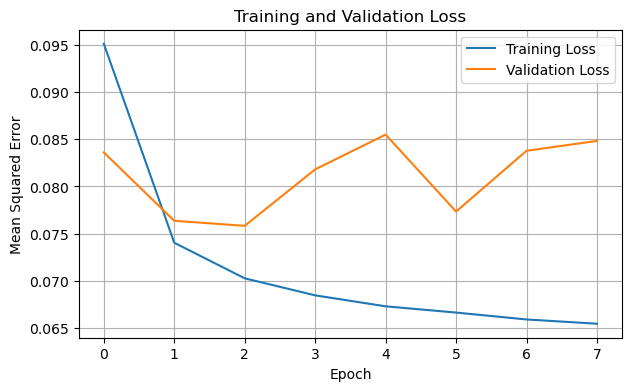

In [24]:
# Step 8: Plot Training and Validation Loss
plt.figure(figsize=(7, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

Interpretation: 

Initial Decrease: Both training and validation loss decrease significantly in the initial epochs, indicating that the model is learning and improving its performance.
Diverging Losses: After a few epochs, the training loss continues to decrease, while the validation loss starts to increase. This is a clear sign of overfitting.
Overfitting: The model is becoming too complex and is starting to memorize the training data rather than learning generalizable patterns. This leads to poor performance on unseen data, as reflected by the increasing validation loss.

That is why the model stopped at Epoch 3!

A well-trained model should ideally have both training and validation loss decreasing and converging to a low value.

Possible Solutions to Address Overfitting:

- Early Stopping: Implement early stopping to stop the training process when the validation loss starts to increase.
- Regularization: Introduce regularization techniques like L1 or L2 regularization to penalize model complexity and prevent overfitting.
- Data Augmentation: Increase the size and diversity of the training data to reduce the model's reliance on the specific training examples.
- Model Architecture: Experiment with different model architectures, such as using simpler models or adding dropout layers to reduce overfitting.


# Dense Neural Network (DNN) second attempt 

Explanation of Modifications:
- L2 Regularization (Ridge): Added to each dense layer to penalize large weights, which helps control overfitting by encouraging the model to keep weights small.
- Increased Dropout: Raised the dropout rate to 0.3 to further reduce overfitting by randomly dropping more neurons during training.
- Early Stopping: Retained early stopping to halt training if the validation loss does not improve, helping avoid unnecessary epochs.
Interpretation
If these adjustments do not fully address the overfitting, you could further increase the regularization strength (increase the l2 parameter) or add more layers with lower complexity (e.g., fewer neurons).

In [7]:
# Assuming df is already loaded with your dataset
target_column = 'Ewltp (g/km)' 
X = df.drop(columns=[target_column]) 
y = df[target_column]

# Step 1: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Scale numerical features (assuming X is already preprocessed with categorical encoding)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scaling the target variable as well (optional but can be helpful)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Step 3: Further split X_train_scaled and y_train_scaled into training and validation sets
X_train_partial, X_val, y_train_partial, y_val = train_test_split(
    X_train_scaled, y_train_scaled, test_size=0.2, random_state=42
)

# Step 4: Build the Neural Network Model with regularization
from tensorflow.keras.regularizers import l2

model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Explicitly define the input shape
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularization
    Dropout(0.3),  # Increased dropout rate
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularization
    Dropout(0.3),  # Increased dropout rate
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularization
    Dense(1)  # Output layer with one neuron for regression output
])

# Compile the model with MSE as the loss function and Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])

# Display the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,857 (38.50 KB)

 Trainable params: 9,857 (38.50 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Step 5: Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

# Step 6: Train the Model
history = model.fit(
    X_train_partial, y_train_partial,
    validation_data=(X_val, y_val),
    epochs=50,           # Keep epochs high, early stopping will manage overfitting
    batch_size=16,       # Smaller batch size - helps manage memory usage
    callbacks=[early_stopping],  # Early stopping to prevent overfitting
    verbose=1
)

# Step 7: Evaluate the Model on the Test Set

# Transform the predictions back to the original scale
y_train_pred = scaler_y.inverse_transform(model.predict(X_train_scaled).flatten().reshape(-1, 1))
y_test_pred = scaler_y.inverse_transform(model.predict(X_test_scaled).flatten().reshape(-1, 1))

# Transform y_train and y_test back to the original scale
y_train_orig = scaler_y.inverse_transform(y_train_scaled.reshape(-1, 1))
y_test_orig = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))

train_mse = mean_squared_error(y_train_orig, y_train_pred)
test_mse_DNN2 = mean_squared_error(y_test_orig, y_test_pred)
train_r2 = r2_score(y_train_orig, y_train_pred)
test_r2_DNN2 = r2_score(y_test_orig, y_test_pred)

# Save metrics for model comparison
model_metrics['DNN2'] = {'MSE': test_mse_DNN2, 'R²': test_r2_DNN2}

print(f"Training MSE: {train_mse}")
print(f"Test MSE DNN2: {test_mse_DNN2}")
print(f"Training R-squared: {train_r2}")
print(f"Test R-squared DNN2: {test_r2_DNN2}")

Epoch 1/50
81112/81112 ━━━━━━━━━━━━━━━━━━━━ 117s 1ms/step - loss: 0.1600 - mse: 0.1187 - val_loss: 0.1286 - val_mse: 0.1077
Epoch 2/50
81112/81112 ━━━━━━━━━━━━━━━━━━━━ 117s 1ms/step - loss: 0.1083 - mse: 0.0875 - val_loss: 0.1684 - val_mse: 0.1479
Epoch 3/50
81112/81112 ━━━━━━━━━━━━━━━━━━━━ 114s 1ms/step - loss: 0.1069 - mse: 0.0867 - val_loss: 0.1562 - val_mse: 0.1363
Epoch 4/50
81112/81112 ━━━━━━━━━━━━━━━━━━━━ 115s 1ms/step - loss: 0.1068 - mse: 0.0869 - val_loss: 0.1466 - val_mse: 0.1270
Epoch 5/50
81112/81112 ━━━━━━━━━━━━━━━━━━━━ 116s 1ms/step - loss: 0.1067 - mse: 0.0868 - val_loss: 0.1395 - val_mse: 0.1196
Epoch 6/50
81112/81112 ━━━━━━━━━━━━━━━━━━━━ 116s 1ms/step - loss: 0.1066 - mse: 0.0868 - val_loss: 0.1581 - val_mse: 0.1385
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
50695/50695 ━━━━━━━━━━━━━━━━━━━━ 44s 863us/step
12674/12674 ━━━━━━━━━━━━━━━━━━━━ 11s 890us/step
Training MSE: 125.05838775634766
Test MSE DNN2: 125.58484649658203
Training R

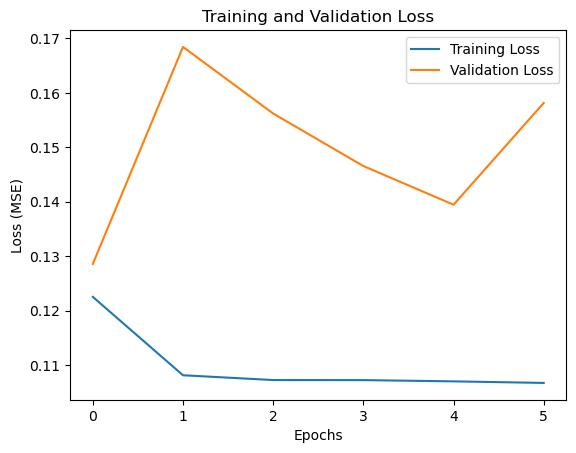

In [9]:
# Step 7: Plot Training and Validation Loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Dense Neural Network (DNN) third attempt

Explanation of Modifications:

- Increased test size, 30 %
- Batch size 32: (Start with a batch size of around 32 and observe the training and validation losses. If you still see overfitting around epoch 3, try increasing it gradually (32 → 64 → 128).)

--

Small Batch Size (e.g., 16): With smaller batches, there is more noise in the gradient updates (i.e., they vary more with each batch). This noise can help escape local minima but may lead to less stable convergence, especially early in training.
Larger Batch Size: Larger batches generally provide a more stable, smooth gradient, which can lead to more stable training and smoother convergence. However, this can sometimes make the model get "stuck" in suboptimal solutions and may not generalize as well, as it can reduce the model's ability to explore the solution space.
Generalization:

Smaller Batches often lead to better generalization, as the noisier updates act like a form of regularization. With too large a batch size, the model might overfit as it converges to a more deterministic gradient update.

In [11]:
# Assuming df is already loaded with your dataset
target_column = 'Ewltp (g/km)' 
X = df.drop(columns=[target_column]) 
y = df[target_column]

# Step 1: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 2: Scale numerical features (assuming X is already preprocessed with categorical encoding)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scaling the target variable as well (optional but can be helpful)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Step 3: Further split X_train_scaled and y_train_scaled into training and validation sets
X_train_partial, X_val, y_train_partial, y_val = train_test_split(
    X_train_scaled, y_train_scaled, test_size=0.3, random_state=42
)

# Step 4: Build the Neural Network Model with regularization
from tensorflow.keras.regularizers import l2

model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Explicitly define the input shape
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularization
    Dropout(0.3),  # Increased dropout rate
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularization
    Dropout(0.3),  # Increased dropout rate
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularization
    Dense(1)  # Output layer with one neuron for regression output
])

# Compile the model with MSE as the loss function and Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])

# Display the model architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,857 (38.50 KB)

 Trainable params: 9,857 (38.50 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Step 5: Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

# Step 6: Train the Model
history = model.fit(
    X_train_partial, y_train_partial,
    validation_data=(X_val, y_val),
    epochs=50,           # Keep epochs high, early stopping will manage overfitting
    batch_size=32,       # Smaller batch size - helps manage memory usage
    callbacks=[early_stopping],  # Early stopping to prevent overfitting
    verbose=1
)

# Step 7: Evaluate the Model on the Test Set

# Transform the predictions back to the original scale
y_train_pred = scaler_y.inverse_transform(model.predict(X_train_scaled).flatten().reshape(-1, 1))
y_test_pred = scaler_y.inverse_transform(model.predict(X_test_scaled).flatten().reshape(-1, 1))

# Transform y_train and y_test back to the original scale
y_train_orig = scaler_y.inverse_transform(y_train_scaled.reshape(-1, 1))
y_test_orig = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))

train_mse = mean_squared_error(y_train_orig, y_train_pred)
test_mse_DNN3 = mean_squared_error(y_test_orig, y_test_pred)
train_r2 = r2_score(y_train_orig, y_train_pred)
test_r2_DNN3 = r2_score(y_test_orig, y_test_pred)

# Save metrics for model comparison
model_metrics['DNN3'] = {'MSE': test_mse_DNN3, 'R²': test_r2_DNN3}

print(f"Training MSE: {train_mse}")
print(f"Test MSE: {test_mse_DNN3}")
print(f"Training R-squared: {train_r2}")
print(f"Test R-squared: {test_r2_DNN3}")

Epoch 1/50
31051/31051 ━━━━━━━━━━━━━━━━━━━━ 52s 2ms/step - loss: 0.1993 - mse: 0.1415 - val_loss: 0.1294 - val_mse: 0.1100
Epoch 2/50
31051/31051 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - loss: 0.1011 - mse: 0.0820 - val_loss: 0.1374 - val_mse: 0.1187
Epoch 3/50
31051/31051 ━━━━━━━━━━━━━━━━━━━━ 83s 2ms/step - loss: 0.0995 - mse: 0.0810 - val_loss: 0.1291 - val_mse: 0.1107
Epoch 4/50
31051/31051 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - loss: 0.0989 - mse: 0.0806 - val_loss: 0.1620 - val_mse: 0.1439
Epoch 5/50
31051/31051 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - loss: 0.0987 - mse: 0.0807 - val_loss: 0.1700 - val_mse: 0.1521
Epoch 6/50
31051/31051 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - loss: 0.0984 - mse: 0.0805 - val_loss: 0.1351 - val_mse: 0.1169
Epoch 7/50
31051/31051 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - loss: 0.0983 - mse: 0.0806 - val_loss: 0.1632 - val_mse: 0.1462
Epoch 8/50
31051/31051 ━━━━━━━━━━━━━━━━━━━━ 52s 2ms/step - loss: 0.0980 - mse: 0.0807 - val_loss: 0.1496 - val_mse: 0.1321
Epoch 8: early s

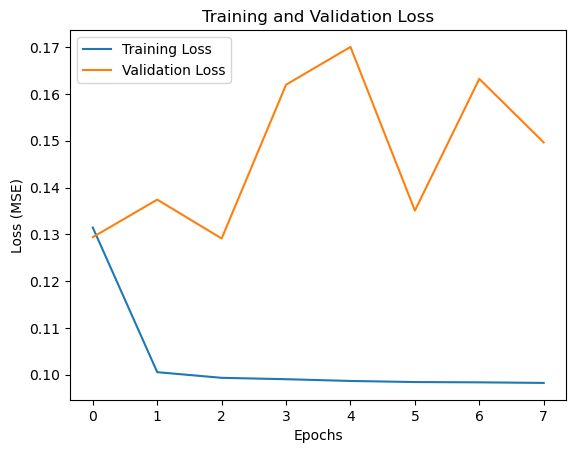

In [13]:
# Step 7: Plot Training and Validation Loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

No fuel consumption: 

Linear Regression 

Training R2: 0.842
Test R2: 0.842
Mean R-squared across folds: 0.820

XG Boost after finding best parameters: 

Best Model Test R-squared: 0.97
Mean R-squared across folds: 0.9551535606384277


Deep learning 1 : 
Test R-squared: 0.92
Deep learning 2 : 
Test R-squared: 0.90




